# 3D printing a pluto data set

In [1]:
from pathlib import Path
import imageio

import numpy as np
from PIL import Image
from scipy.interpolate import RegularGridInterpolator

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astro3d
from astro3d.image_stack import makeslice, process

plt.style.use([{'image.cmap':'gray_r'}])

Read data.

In [2]:
with np.load(astro3d.get_data('pluto_dust_box.npz')) as f:
    x = f['x']
    y = f['y']
    z = f['z']
    data = f['rho']

## Normalization

Find the largest magnitude of the data values and define a logarithmic norm

In [3]:
vmax = 10**np.ceil(np.log10(data.max()))
norm = LogNorm(1e-6 * vmax, 1e-2 * vmax, clip=True)

## Upscale the data

### Coordinates & aspect ratios

these are the original "coordinates" of the pixels

In [4]:
x = np.linspace(0, data.shape[0] - 1, data.shape[0])
y = np.linspace(0, data.shape[1] - 1, data.shape[1])
z = np.linspace(0, data.shape[2] - 1, data.shape[2])

create an interpolation function for the 3d data

In [19]:
def f_interp(coords):
    return astro3d.fmodule.interpolate(x, y, z, data, coords)

settings of the printer (educated guess, especially the layer thickness might be different)

In [20]:
height = 5 # this should be the total height of the object. Other dimensions should be scaled to keep the aspect ratio

# these are the values of the J850 prime
dpi_x = 600
dpi_y = 300
# dpi_z = 1814 # 0.014 mm layer thickness
dpi_z = 940 # 0.027 mm layer thickness

# layer_thickness = 2.54 / dpi_z#55e-4 # 14 micron

calculate the new grids in x, y, z

In [21]:
n_z = int(height * dpi_z / 2.54)
n_x = int(n_z * len(x) / len(z) / dpi_z * dpi_x)
n_y = int(n_z * len(y) / len(z) / dpi_z * dpi_y)

n_x += n_x % 2  # add 1 to make it even if it isn't
n_y += n_y % 2  # add 1 to make it even if it isn't

x2 = np.linspace(0, data.shape[0] - 1, n_x)
y2 = np.linspace(0, data.shape[1] - 1, n_y)
z2 = np.linspace(0, data.shape[2] - 1, n_z)

coords = (x2, y2, z2)

### Iteration

we get the new layer by interpolating the 3D data. We store the images in the path set by `output_dir`.

In [22]:
output_dir = 'slices_pluto_v02'

Prepare output folder

In [23]:
path = Path(output_dir)

if not path.is_dir():
    path.mkdir()
else:
    files = list(path.glob('slice*.png'))
    if len(files)>0:
        print('directory exists, deleting old files')
        for file in files:
            file.unlink()

directory exists, deleting old files


select which index in the new z-grid to process

In [24]:
iz = n_z//2

This cell does the same as `makeslice`: interpolates one layer, creates and dithers the image and writes it to file

In [28]:
coords2 = np.array(np.meshgrid(x2, y2, z2[iz])).squeeze().reshape(3, -1).T

# interpolate: note that we transpose as this is how the image will be safed
new_layer = f_interp(coords2).reshape(len(y2), len(x2))

# normalize, convert to grayscale image
layer_norm = np.array(norm(new_layer))
layer_norm[np.isnan(layer_norm)] = 0.0
layer_dither = astro3d.fmodule.dither_colors(layer_norm[:, :, None])

# save as png
imageio.imwrite(path / f'slice_{iz:04d}.png', np.uint8(255 - 255 * layer_dither))

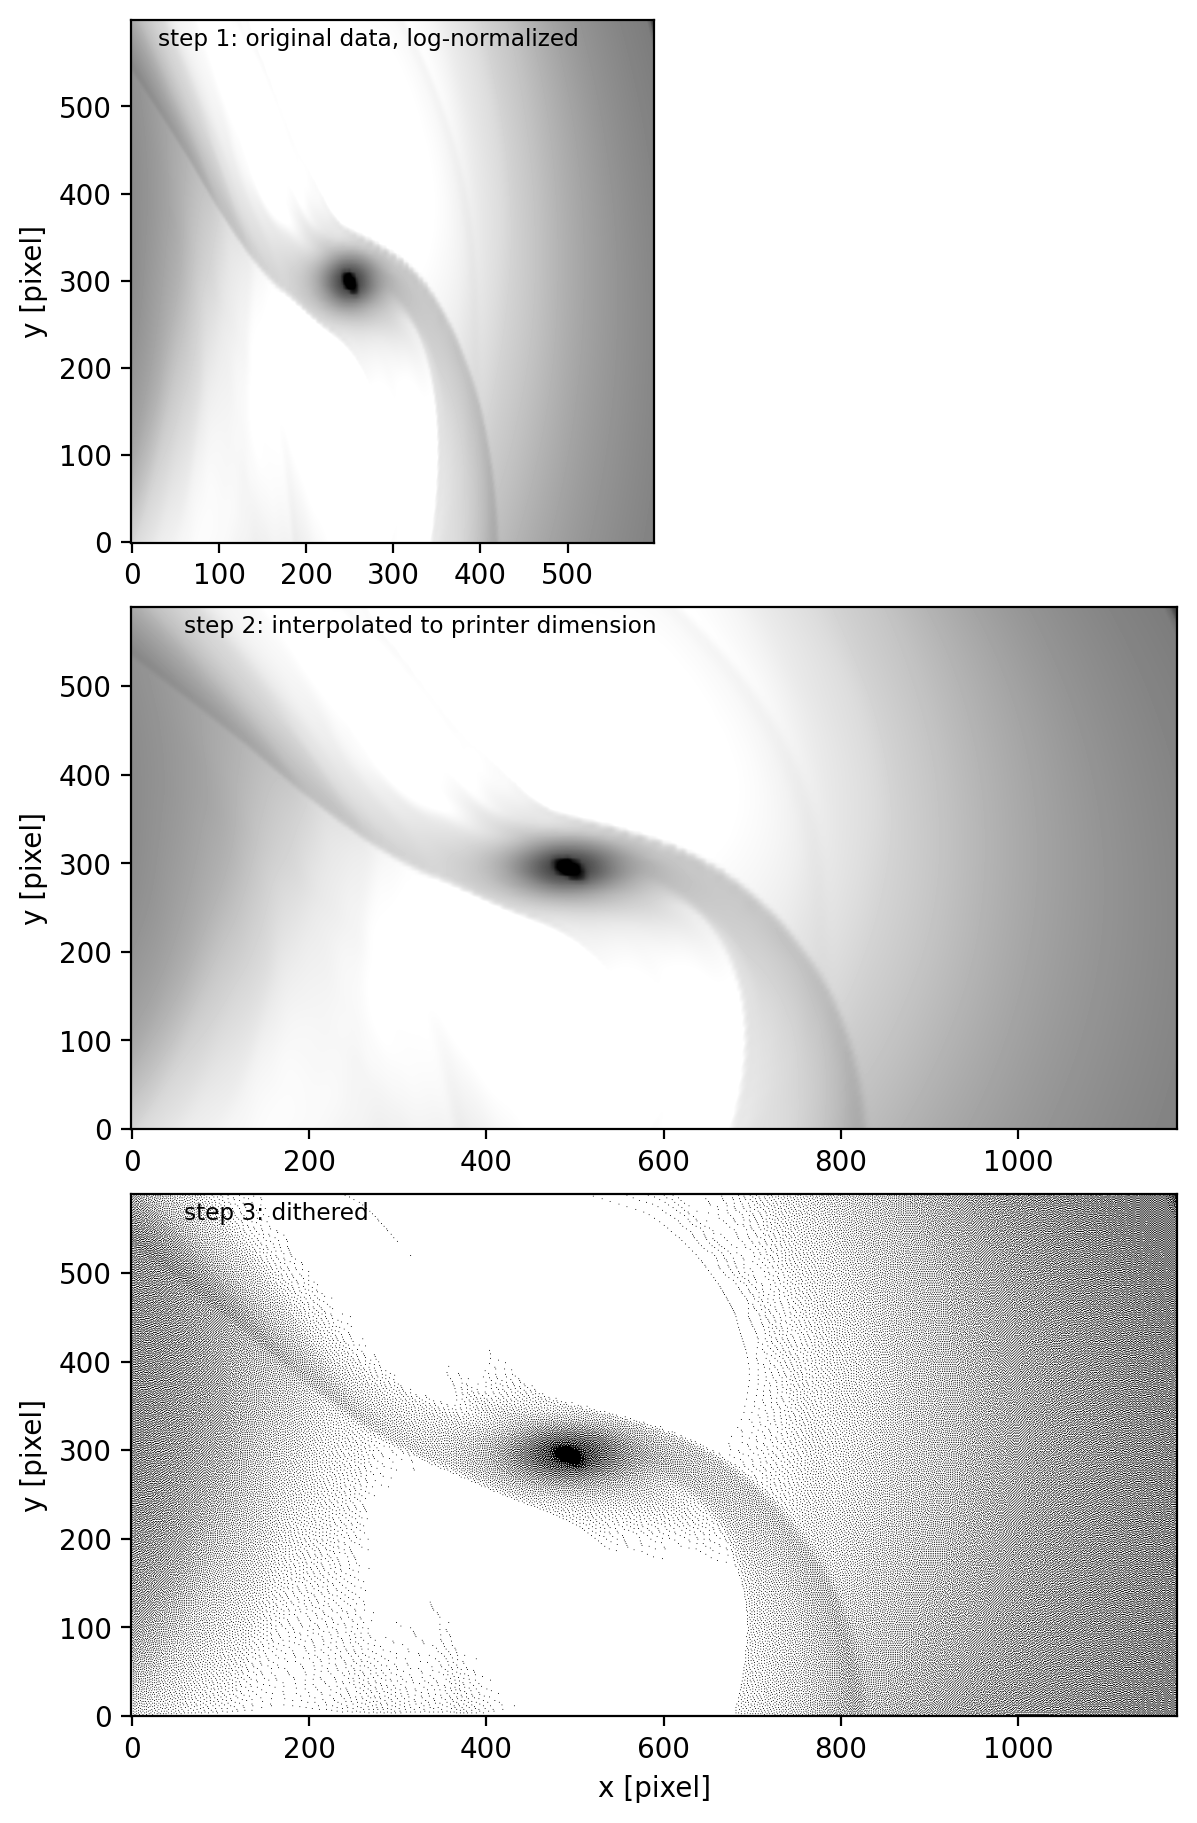

In [29]:
iz2 = z.searchsorted(z2[iz])

f, axs = plt.subplots(3, 1, dpi=100, figsize=(2 * 3, 3 * 3), constrained_layout=True)
axs[0].imshow(norm(data[:, :, iz2]).T, vmin=0, vmax=1, origin='lower')
axs[1].imshow(layer_norm, vmin=0, vmax=1, origin='lower')
axs[2].imshow(layer_dither, vmin=0, vmax=1, origin='lower')
axs[0].text(0.05, 0.95, 'step 1: original data, log-normalized', fontsize='small', transform=axs[0].transAxes)
axs[1].text(0.05, 0.95, 'step 2: interpolated to printer dimension', fontsize='small', transform=axs[1].transAxes)
axs[2].text(0.05, 0.95, 'step 3: dithered', fontsize='small', transform=axs[2].transAxes)

for ax in axs:
    ax.set_ylabel('y [pixel]')
    ax.set_anchor('W')
axs[-1].set_xlabel('x [pixel]');

this is the same result using `makeslice`

In [30]:
makeslice(iz, z2, f_interp, coords, norm, path);

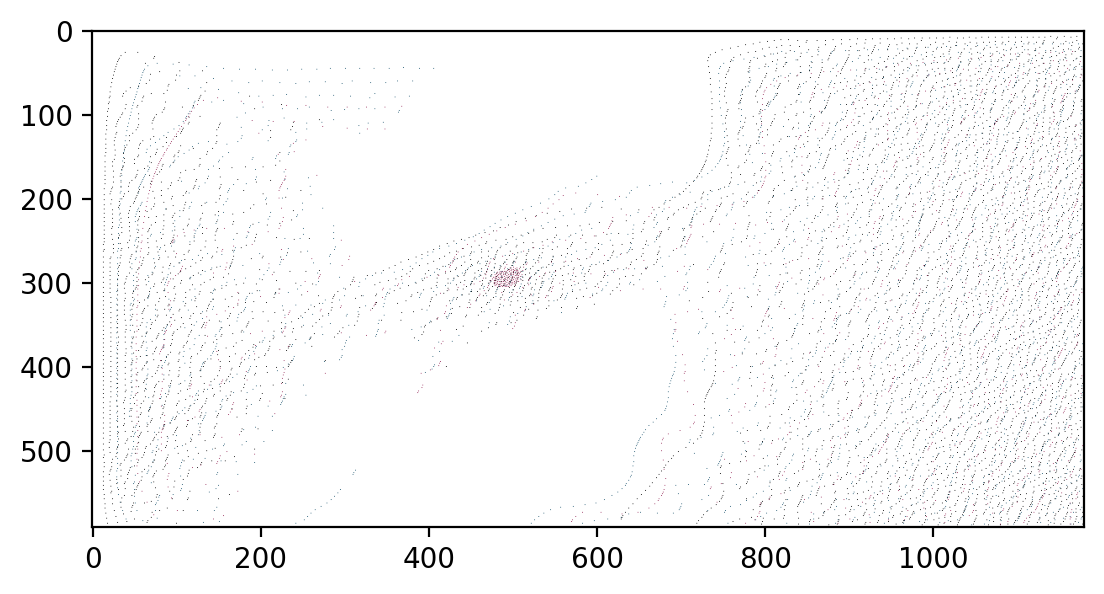

In [41]:
levels = np.array([0.2, 0.8, 0.95])
sigmas = np.array([-0.1, 0.25, 0.05])
fill = np.array([.05, 0.02, 0.3])
clip = np.array([3.0, 3.0, 2])

colors = np.array([[0, 0, 0], astro3d.image_stack.VeroC_sRGB, astro3d.image_stack.VeroM_sRGB])

makeslice(iz, z2, f_interp, coords, norm, path,
    levels=levels,
    sigmas=sigmas,
    fill=fill,
    colors=colors);

plt.imshow(imageio.v3.imread(path / f'slice_{iz:04d}.png'))

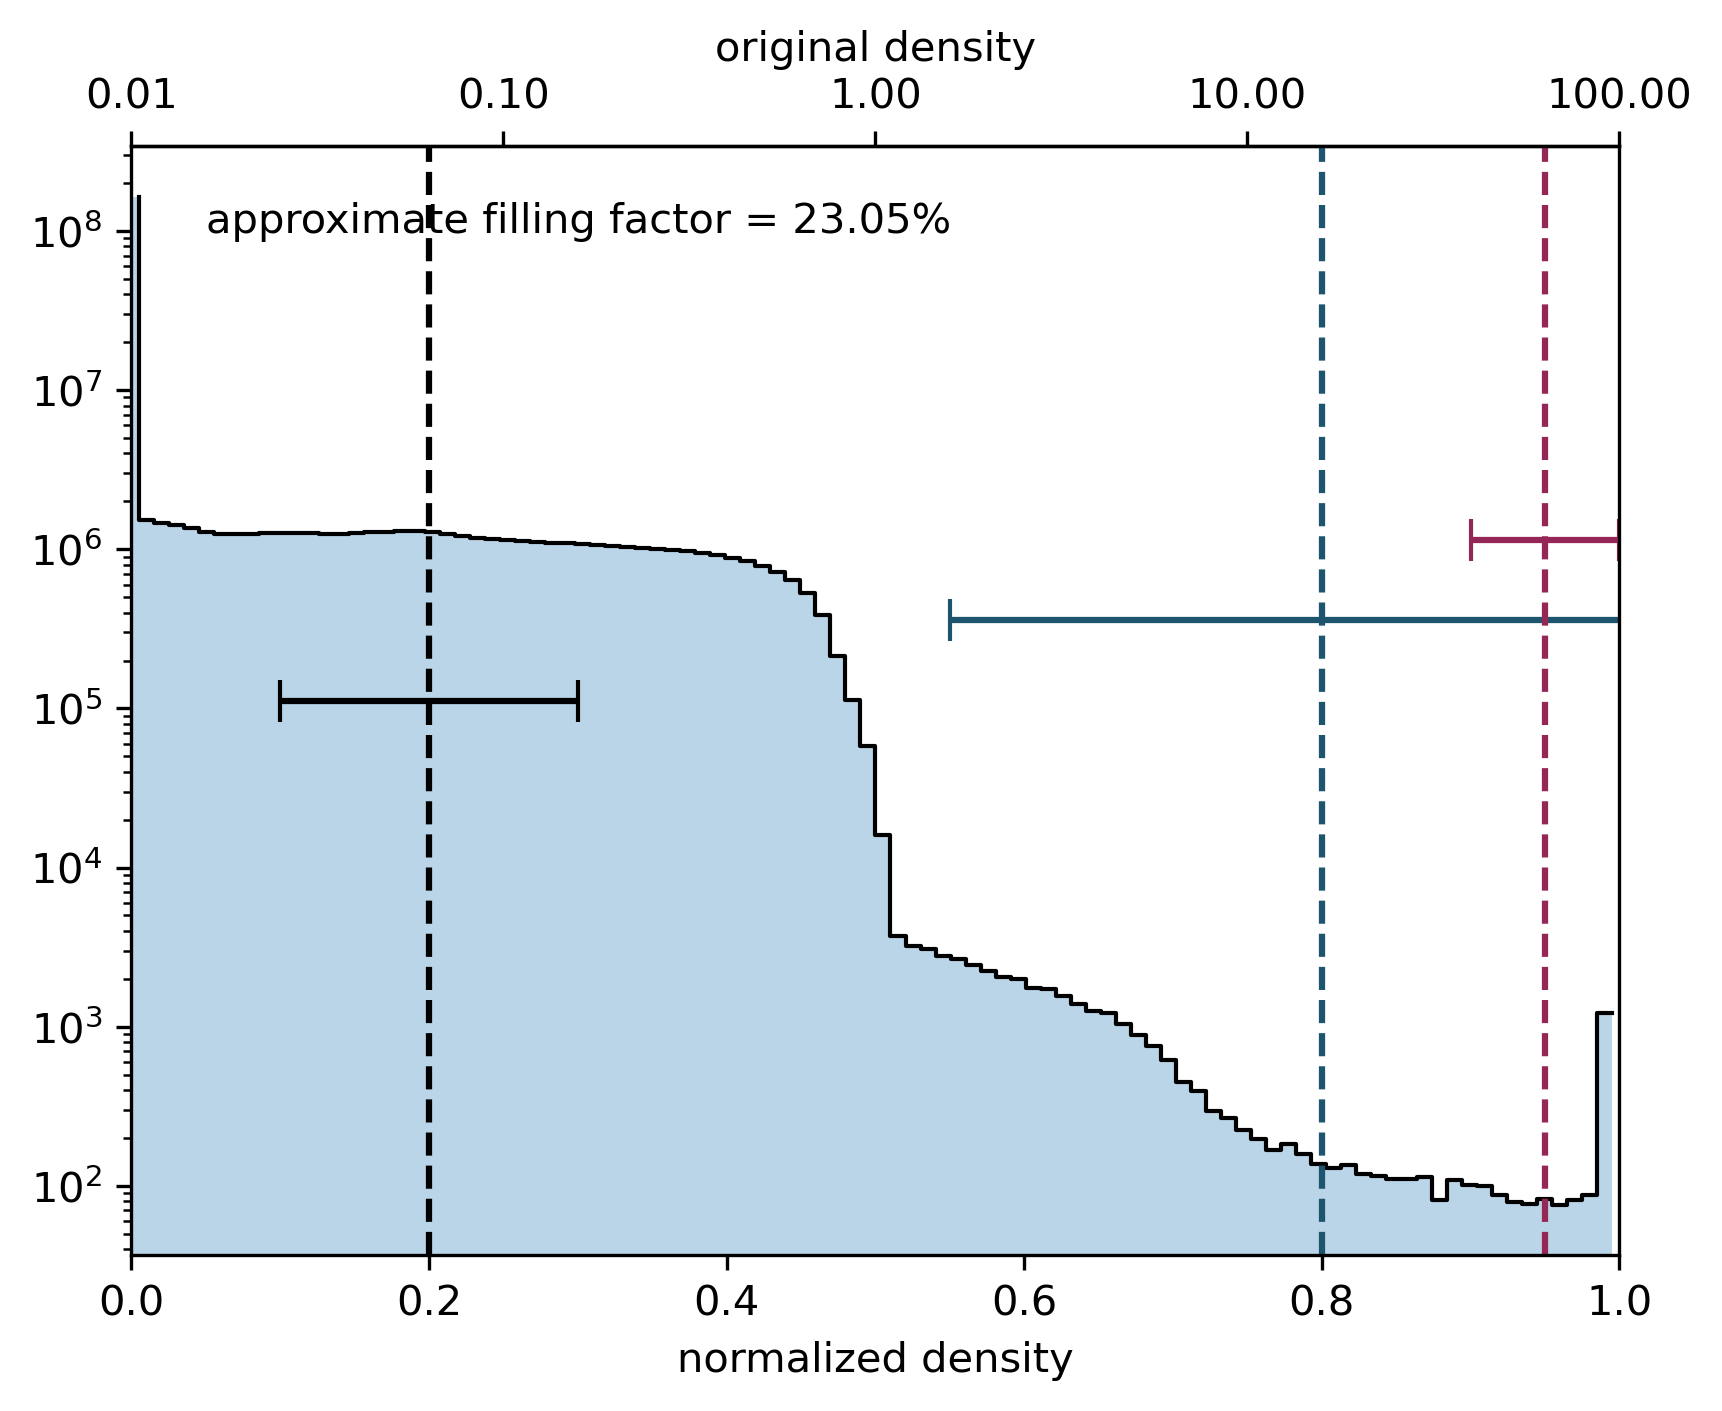

In [42]:
astro3d.image_stack.show_histogram(data, norm, colors=colors, levels=levels, sigmas=np.abs(sigmas))

get the colors in that slice

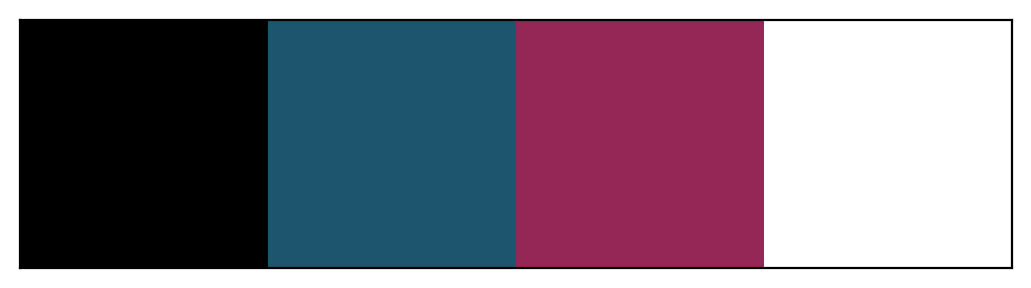

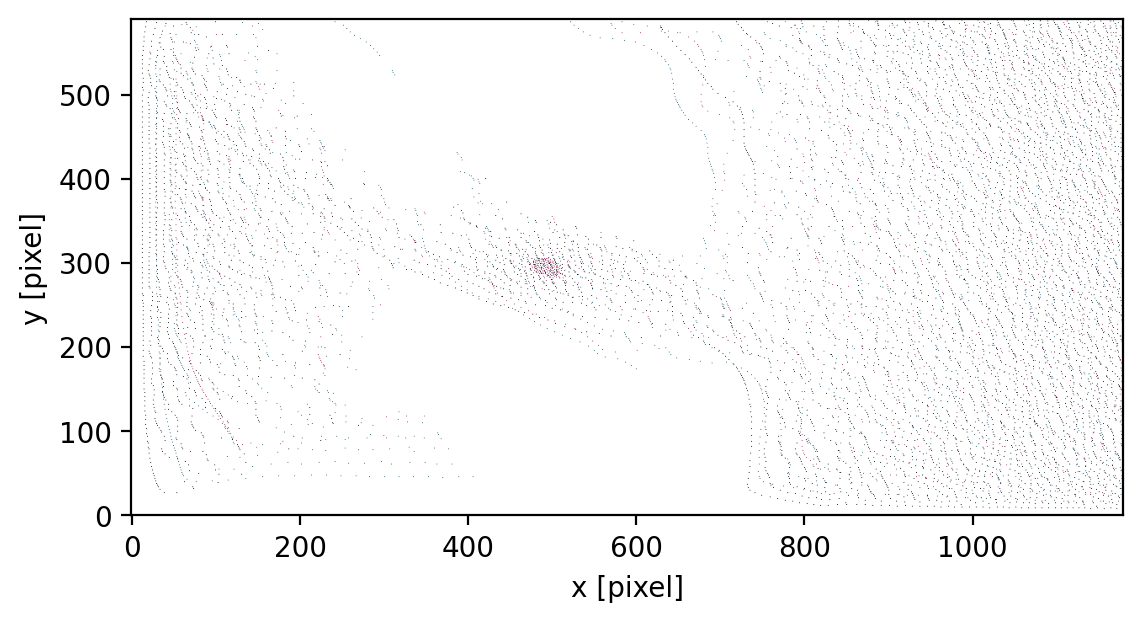

In [43]:
im = imageio.v2.imread(path / f'slice_{iz:04d}.png')
cols = astro3d.image_stack.check_colors(im)

plt.imshow([cols]).axes.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)

f, ax = plt.subplots()
ax.imshow(im, origin='lower')
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]');

## Batch processing

all of the above can also be done in a loop with `process`:
normalizing with the given norm, up-scaling and saving to images. We'll just do this same one here by specifying the `iz` keyword.

Here we just want to print the first cm.

In [44]:
#izs = np.arange(int(dpi_z / 2.54))
izs = np.arange(n_z)

In [45]:
from tqdm.auto import tqdm

In [46]:
for _iz in tqdm(izs):
    makeslice(_iz, z2, f_interp, coords, norm, path,
                    levels=levels, sigmas=sigmas, fill=fill,
                    colors=colors, f=np.ones(3), bg=0.7)

  0%|          | 0/1850 [00:00<?, ?it/s]

In [ ]:
process(data,
        height=height, dpi_x=dpi_x, dpi_y=dpi_y, dpi_z=dpi_z,
        output_dir=output_dir,
        norm=norm,
       )